# Deep Reinforcement Learning: CartPole with DQN

In [17]:
import gymnasium as gym
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


### DQN Agent

DQN (Deep Q-Network) that inherits from `torch.nn` module. A simple feed-forward network with two hidden layers of size `hidden_size`. Takes the environment state (a vector of length `input_size`) and outputs **Q-values** ffor each of the `output_size` actions

In [18]:
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        return self.out(x)
    

### ReplayBuffer

A datastructure (buffer) to efficiently store experiences, that we may sample a tuple containing `(state, action, reward, next_state, done)` from, get the length of the buffer and add batches to it

In [19]:
class ReplayBuffer:
    """A simple replay buffer to store experiences"""
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    # args is a tuple of (state, action, reward, next_state, done)
    def push(self, *args):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = args
        self.position = (self.position + 1) % self.capacity

    # sample a batch of experiences from the buffer
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

### Target Network Update

if `soft` then:
for each parameter 
* we take a fraction (`tau`) of the corresponding parameter from the `model`
* we take a large fraction (`1-tau`) of the **current** parameter from the `target_model`

else (`hard`) then:
load the weights and biases of `model` into `target_model`


In [39]:
def update_target_model(model, target_model, soft=False, tau=0.1):
    """
    Update the target model with the online model's weights (main network).
    Parameters:
    - model: The online model.
    - target_model: The target model.
    - soft: If True, use soft update (tau) instead of hard update.
    - tau: The interpolation factor for soft update.
      """
    if soft:
        target_model_state_dict = target_model.state_dict()
        model_state_dict = model.state_dict()
        for key in model_state_dict:
            target_model_state_dict[key] = model_state_dict[key]*tau + target_model_state_dict[key]*(1-tau)
        target_model.load_state_dict(target_model_state_dict)
    else:
        target_model.load_state_dict(model.state_dict())



### DQN Loss Function

Computes the loss for the DQN Agent. Implements the **Bellman Backup** 

$$L = E\bigg[Q(s, a) - (r + \gamma \ \mathrm{max}_a Q'(s´,a´)))^2 \bigg]$$



In [40]:
def dqn_loss(model, target_model, batch, gamma):
    states, actions, rewards, next_states, dones = zip(*batch)

    # convert to tensors  --------------------------------------------------
    states      = torch.tensor(np.array(states),      dtype=torch.float32)  # <-- FIX (np.array)
    actions     = torch.tensor(actions,               dtype=torch.int64).unsqueeze(1)
    rewards     = torch.tensor(rewards,               dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32)  # <-- FIX
    dones       = torch.tensor(dones,                 dtype=torch.float32).unsqueeze(1)
    # ---------------------------------------------------------------------

    q_values   = model(states).gather(1, actions)
    next_q     = target_model(next_states).max(1, keepdim=True)[0].detach()
    expected_q = rewards + (1 - dones) * gamma * next_q

    return nn.MSELoss()(q_values, expected_q)


### Train Model

Takes a batch of past experiences and calculates how wrong the current model predictions are (i.e the loss from `dqn_loss(...)`) and then updates the models weights to make its predictions better in future iterations

* `model` is the online network meanwhile `target_model` is the frozen (or slowly) updated target network (the target Q-network). 
* `optimizer` is the PyTorch `Adam` that will update the `model`s weights
* `replay_buffer` is the replaybuffer object from `ReplayBuffer` class
* `gamma` is the discount factor used in the Q-learning update rule, determining the importance of future rewards

In [41]:
def train_model(model, target_model, replay_buffer,
                optimizer, batch_size, gamma):
    if len(replay_buffer) < batch_size:
        return

    batch = replay_buffer.sample(batch_size)
    loss  = dqn_loss(model, target_model, batch, gamma)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


## $\epsilon$-greedy policy

Implements the $\epsilon$-greedy action selection strategy (in order to balance **exploration** and **exploitation**)

* **Exploration**: If the `random.random()` is less than `epsilon`, the agent **explore** (not using its current knowledge)

* **Exploitation**: If the `random.random()` is **not** less than `epsilon`, the agent **exploits** its current knowledge, using Q-values from the model with the current state


In [42]:
def e_greedy(state, model, epsilon, action_dim):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state = torch.FloatTensor(state).unsqueeze(0)  
        with torch.no_grad():
            q_values = model(state)
        return q_values.argmax().item()


### Main function (training loop)

Hyperparameters
```input_size
    hidden_size
    output_size
    num_episodes
    batch_size
    gamma
    learning_rate
    target_update_freq
    replay_buffer_capacity
```

Continues on until `CartPole` environment-step gives `done=True`

Episode    1/1000 — return:  19.0
Episode    2/1000 — return:  32.0
Episode    3/1000 — return:  11.0
Episode    4/1000 — return:  12.0
Episode    5/1000 — return:   8.0
Episode    6/1000 — return:  12.0
Episode    7/1000 — return:  10.0
Episode    8/1000 — return:  12.0
Episode    9/1000 — return:  10.0
Episode   10/1000 — return:   9.0
Episode   11/1000 — return:   9.0
Episode   12/1000 — return:   9.0
Episode   13/1000 — return:  10.0
Episode   14/1000 — return:   9.0
Episode   15/1000 — return:  11.0
Episode   16/1000 — return:  10.0
Episode   17/1000 — return:  10.0
Episode   18/1000 — return:   9.0
Episode   19/1000 — return:  10.0
Episode   20/1000 — return:  11.0
Episode   21/1000 — return:  10.0
Episode   22/1000 — return:   9.0
Episode   23/1000 — return:  10.0
Episode   24/1000 — return:  10.0
Episode   25/1000 — return:   9.0
Episode   26/1000 — return:  10.0
Episode   27/1000 — return:  10.0
Episode   28/1000 — return:  10.0
Episode   29/1000 — return:   9.0
Episode   30/1

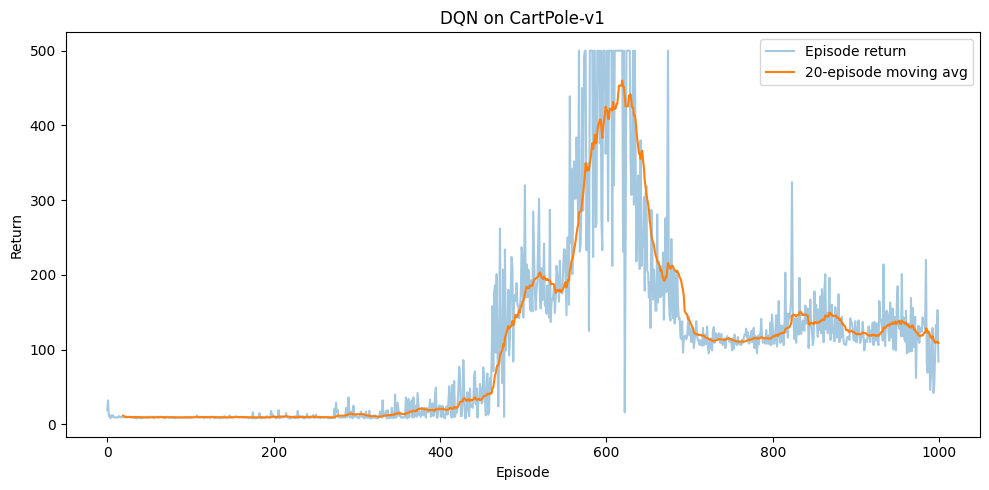

In [64]:
def main():
    env = gym.make("CartPole-v1")
    input_size  = env.observation_space.shape[0]
    hidden_size = 128
    output_size = env.action_space.n

    num_episodes           = 1000
    batch_size             = 64
    gamma                  = 0.99
    learning_rate          = 1e-3
    target_update_freq     = 10
    replay_buffer_capacity = 10000

    epsilon       = 1.0
    epsilon_decay = 0.98
    epsilon_min   = 0.001

    warmup_steps  = 1000  # Number of steps to fill the replay buffer before training
    total_steps   = 0

    online_net = DQN(input_size, hidden_size, output_size)
    target_net = DQN(input_size, hidden_size, output_size)
    target_net.load_state_dict(online_net.state_dict())

    optimizer = optim.Adam(online_net.parameters(), lr=learning_rate)
    buffer    = ReplayBuffer(replay_buffer_capacity)

    episode_returns = []                     # ← NEW
    learning_enabled = True                 # flag to control training

    for episode in range(num_episodes):
        state, _ = env.reset(seed=episode)
        done, ep_return = False, 0.0

        while not done:
            action = e_greedy(state, online_net, epsilon, output_size)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            buffer.push(state, action, reward, next_state, done)

            state, ep_return = next_state, ep_return + reward
            total_steps += 1

            # training step only if learning_enabled
            if learning_enabled and total_steps > warmup_steps and len(buffer) >= batch_size:
                train_model(online_net, target_net, buffer,
                            optimizer, batch_size, gamma)

            epsilon = max(epsilon * epsilon_decay, epsilon_min)

        episode_returns.append(ep_return)    # ← NEW
        print(f"Episode {episode+1:4d}/{num_episodes} — return: {ep_return:5.1f}")

        if learning_enabled and (episode + 1) % target_update_freq == 0:
            update_target_model(online_net, target_net, soft=True, tau=0.05)
        # Check for stability: reduce learning if average return > 450 over last 20 episodes
        if len(episode_returns) >= 20:
            avg_return = np.mean(episode_returns[-20:])
            if avg_return > 475:
                print(f"Average return over last 20 episodes reached {avg_return:.1f}, disabling further training for stability.")
                learning_enabled = False
    env.close()

    # ── Plot learning curve ────────────────────────────────────────
    plt.figure(figsize=(10, 5))
    plt.plot(episode_returns, alpha=0.4, label="Episode return")

    # Smooth with a simple moving average (window = 20)
    if len(episode_returns) >= 20:
        ma = np.convolve(episode_returns,
                         np.ones(20)/20, mode="valid")
        plt.plot(range(19, num_episodes), ma, label="20-episode moving avg")

    plt.title("DQN on CartPole-v1")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.legend()
    plt.tight_layout()

    # If interactive backend available this will show a pop-up; otherwise save to file
    try:
        plt.show()
    except:
        plt.savefig("training_curve.png")
        print("Saved training curve to training_curve.png")

if __name__ == "__main__":
    main()

In [43]:
def main():
    # Hyperparameters
    env = gym.make('CartPole-v1') # use gymnasium for the latest version
    input_size = env.observation_space.shape[0]
    hidden_size = 128
    output_size = env.action_space.n
    num_episodes = 1000
    batch_size = 64
    gamma = 0.99
    learning_rate = 0.001
    target_update_freq = 10
    replay_buffer_capacity = 10000

    # init the environment, model, optimizer, and replay buffer<
    model = DQN(input_size, hidden_size, output_size)
    print("model", model)
    target_model = DQN(input_size, hidden_size, output_size)
    target_model.load_state_dict(model.state_dict())
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(replay_buffer_capacity)

    # main training loop
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            # using our greedy function
            action = e_greedy(
                state, model, epsilon=0.1, action_dim=output_size
            )

            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward

            # store experience in replay buffer
            replay_buffer.push(state, action, reward, next_state, done)

            # update the state
            state = next_state

        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")

        # train the model
        train_model(model, target_model, replay_buffer, optimizer, batch_size, gamma)

        # update the target model every few (10) episodes
        if episode % target_update_freq == 0:
            update_target_model(model, target_model, soft=True, tau=0.005)

In [28]:
main()

model DQN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (relu2): ReLU()
  (out): Linear(in_features=128, out_features=2, bias=True)
)
Episode 1/1000, Total Reward: 12.0
Episode 2/1000, Total Reward: 15.0
Episode 3/1000, Total Reward: 16.0
Episode 4/1000, Total Reward: 14.0
Episode 5/1000, Total Reward: 12.0
Episode 6/1000, Total Reward: 14.0
Episode 7/1000, Total Reward: 15.0
Episode 8/1000, Total Reward: 15.0
Episode 9/1000, Total Reward: 24.0
Episode 10/1000, Total Reward: 12.0
Episode 11/1000, Total Reward: 18.0
Episode 12/1000, Total Reward: 14.0
Episode 13/1000, Total Reward: 16.0
Episode 14/1000, Total Reward: 18.0
Episode 15/1000, Total Reward: 19.0
Episode 16/1000, Total Reward: 16.0
Episode 17/1000, Total Reward: 14.0
Episode 18/1000, Total Reward: 19.0
Episode 19/1000, Total Reward: 14.0
Episode 20/1000, Total Reward: 13.0
Episode 21/1000, Total Reward: 16.0
Episode 22/1000, Total 